## Preprocessing and understanding the data

In [6]:
import pandas as pd
import re, string

In [7]:
data = pd.read_csv('../Data/data.csv')
data.head()

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


In [8]:
data.shape

(5000, 2)

In [9]:
# drop rows with missing values
data.dropna(inplace=True)

data.shape

(5000, 2)

In [10]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

In [13]:
def preprocessing(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [14]:
data.head()

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

In [16]:
# lets grab all unique values from topic and then use them as our target
target = data['topic'].unique()
target

array(['Sales/Promotions', 'Shipping', 'Product Availability',
       'Product Specifications', 'Omnichannel', 'Product Comparison',
       'Returns & Refunds'], dtype=object)

In [17]:
# split the data into train
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_X = train.drop('topic', axis=1)

In [18]:
train.shape, test.shape

((4000, 2), (1000, 2))

In [19]:
# Lets vectorize the data
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# create the transform
vectorizer = TfidfVectorizer(tokenizer=preprocessing, ngram_range=(1, 2), stop_words=None, min_df=0.001, max_df=0.75, max_features=2500)

train_vectors = vectorizer.fit_transform(train_X['question'])

In [21]:
test_vector = vectorizer.transform(test['question'])

In [22]:
train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names())
train_df = pd.concat([train_df, train['topic']], axis=1)

c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
scores_table = pd.DataFrame(columns=['model', 'train_score', 'test_score'])

## select (1) one multi-class classifier (e.g., Naive Bayes, Logistic, Decision Tree, SVM) whose code is provided in class handouts

In [24]:
# Lets use svm to train the model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [25]:
# create the model, this is a multi-class classification problem
model = SVC(kernel='linear', C=1, gamma='auto', probability=True)

# fit the model
model.fit(train_vectors, train['topic'])

SVC(C=1, gamma='auto', kernel='linear', probability=True)

In [26]:
# predict the test data
pred = model.predict(test_vector)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.952

In [27]:
# train score vs. test score
model.score(train_vectors, train['topic']), model.score(test_vector, test['topic'])

(0.98725, 0.952)

In [28]:
# store the scores
scores_table = scores_table.append({'model': 'TFIDF NGRAM 1-2 -> SVC', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

In [29]:
# Lets use the model to predict the topic of a question
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# vectorize the questions
questions_vector = vectorizer.transform(questions)

for question, topic in zip(questions, model.predict(questions_vector)):
    print(f"{question} -> {topic}")

I'm really interested in your special deals. Do you have any offers? -> Sales/Promotions
I'm looking for a new car. What are your best deals? -> Product Availability
What kind of payment methods do you accept? -> Product Specifications
I was wondering if you could ship to my country? -> Shipping


## (2) one ensemble classifier whose code is also provided (e.g., Random Forest, XGBoost)

In [30]:
# Lets use an ensemble classifier to improve the accuracy
from sklearn.ensemble import RandomForestClassifier

In [31]:
# create the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

# fit the model
model.fit(train_vectors, train['topic'])

# predict the test data
pred = model.predict(test_vector)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.847

In [32]:
# train score vs. test score
model.score(train_vectors, train['topic']), model.score(test_vector, test['topic'])

(0.863, 0.847)

In [33]:
scores_table = scores_table.append({'model': 'TFIDF NGRAM 1-2 -> Random Forest', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

In [34]:
# Lets use the model to predict the topic of a question
question = "I'm really interested in your special deals. Do you have any offers?"

# preprocess the question
question = preprocessing(question)

# vectorize the question
question_vector = vectorizer.transform([' '.join(question)])

# predict the topic
model.predict(question_vector)

array(['Product Specifications'], dtype=object)

## (3) one other model of your choice whose code is NOT provided in class handouts (this will require some independent research on your part).

In [35]:
# Lets use MLP to train the model
from sklearn.neural_network import MLPClassifier

In [ ]:
# create the model, this is a multi-class classification problem
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.001, solver='sgd', verbose=10,  random_state=21, tol=0.000000001)

# fit the model
model.fit(train_vectors, train['topic'])

# predict the test data
pred = model.predict(test_vector)

# calculate the accuracy
accuracy_score(test['topic'], pred)

In [37]:
# train score vs. test score
model.score(train_vectors, train['topic']), model.score(test_vector, test['topic'])

(0.999, 0.955)

In [38]:
scores_table = scores_table.append({'model': 'TFIDF NGRAM 1-2 -> MLP', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

In [39]:
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# vectorize the questions
questions_vector = vectorizer.transform(questions)

for question, topic in zip(questions, model.predict(questions_vector)):
    print(f"{question} -> {topic}")

I'm really interested in your special deals. Do you have any offers? -> Sales/Promotions
I'm looking for a new car. What are your best deals? -> Sales/Promotions
What kind of payment methods do you accept? -> Product Specifications
I was wondering if you could ship to my country? -> Shipping


## For each classifier, use four kinds of input feature vectors: (1) TF-IDF vector of tokenized words, (2) TF-IDF vector of n-grams (of range 4-5), (3) word vectors (Glove, Word2Vec, or FastText), and (4) document vectors (Doc2Vec). Train each model using training data, report classification metrics using test data, and summarize the results of all model in a nicely formatted table. Comment on which model will be your preferred choice for text classification for this data and why.

### Part 2.1) NGram Range 4-5

In [40]:
# Lets recreate our input feature with TF-IDF with n-grams (4, 5)
vectorizer_2 = TfidfVectorizer(tokenizer=preprocessing, ngram_range=(4, 5), stop_words=None, min_df=0.001, max_df=0.75, max_features=2500)

train_vectors_2 = vectorizer_2.fit_transform(train_X['question'])

In [41]:
# Repeat the same steps as above
train_df_2 = pd.DataFrame(train_vectors_2.toarray(), columns=vectorizer.get_feature_names())

train_df_2 = pd.concat([train_df_2, train['topic']], axis=1)

test_vector_2 = vectorizer_2.transform(test['question'])

c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
# Create SVC model
model = SVC(kernel='linear', C=1, gamma='auto', probability=True)

# fit the model
model.fit(train_vectors_2, train['topic'])

# predict the test data
pred = model.predict(test_vector_2)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.629

In [43]:
# train score vs. test score
model.score(train_vectors_2, train['topic']), model.score(test_vector_2, test['topic'])

(0.67175, 0.629)

In [44]:
scores_table = scores_table.append({'model': 'TFIDF NGRAM 4-5 -> SVC', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

In [45]:
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# vectorize the questions
questions_vector = vectorizer_2.transform(questions)

for question, topic in zip(questions, model.predict(questions_vector)):
    print(f"{question} -> {topic}")

I'm really interested in your special deals. Do you have any offers? -> Product Specifications
I'm looking for a new car. What are your best deals? -> Product Specifications
What kind of payment methods do you accept? -> Product Specifications
I was wondering if you could ship to my country? -> Product Specifications


In [46]:
# Lets train a Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

# fit the model
model.fit(train_vectors_2, train['topic'])

# predict the test data
pred = model.predict(test_vector_2)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.36

In [47]:
# train score vs. test score
model.score(train_vectors_2, train['topic']), model.score(test_vector_2, test['topic'])

(0.3635, 0.36)

In [48]:
scores_table = scores_table.append({'model': 'TFIDF NGRAM 4-5 -> Random Forest', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

In [49]:
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# vectorize the questions
questions_vector = vectorizer_2.transform(questions)

for question, topic in zip(questions, model.predict(questions_vector)):
    print(f"{question} -> {topic}")

I'm really interested in your special deals. Do you have any offers? -> Product Specifications
I'm looking for a new car. What are your best deals? -> Product Specifications
What kind of payment methods do you accept? -> Product Specifications
I was wondering if you could ship to my country? -> Product Specifications


In [ ]:
# Lets do another model using MLP
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.001, solver='sgd', verbose=10,  random_state=21, tol=0.000000001)

# fit the model
model.fit(train_vectors_2, train['topic'])

# predict the test data
pred = model.predict(test_vector_2)

# calculate the accuracy
accuracy_score(test['topic'], pred)

In [51]:
# train accuracy vs. test accuracy
model.score(train_vectors_2, train['topic']), model.score(test_vector_2, test['topic'])

(0.67175, 0.641)

In [52]:
scores_table = scores_table.append({'model': 'TFIDF NGRAM 4-5 -> MLP', 'train_score': model.score(train_vectors, train['topic']), 'test_score': model.score(test_vector, test['topic'])}, ignore_index=True)

### Part 2.2) Using Word2Vec Word Vectors

In [55]:
# Lets recreate our input feature using Word2Vec
from gensim.models import Word2Vec, KeyedVectors

# load pre-trained word2vec model
wv = KeyedVectors.load_word2vec_format('../Data/GoogleNews-vectors-negative300.bin', binary=True)
wv.init_sims(replace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_29052\264229428.py:6: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  wv.init_sims(replace=True)


In [56]:
# create a function to get the average word2vec
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# create a function to get the word2vec for each question
def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['question'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                       generate_missing=generate_missing))
    return list(embeddings)



In [57]:
# get the word2vec embeddings for the training data
train_word2vec = get_word2vec_embeddings(wv, train_X)

# get the word2vec embeddings for the test data
test_word2vec = get_word2vec_embeddings(wv, test)

In [58]:
# Train SVC model
model = SVC(kernel='linear', C=1, gamma='auto', probability=True)

# fit the model
model.fit(train_word2vec, train['topic'])

# predict the test data
pred = model.predict(test_word2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.473

In [59]:
# train score vs. test score
model.score(train_word2vec, train['topic']), model.score(test_word2vec, test['topic'])

(0.489, 0.473)

In [60]:
scores_table = scores_table.append({'model': 'Word2Vec -> SVC', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [61]:
# Lets use the model to predict the topic of a question
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the word2vec embeddings for the questions
questions_word2vec = get_word2vec_embeddings(wv, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_word2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Comparison

Question: look best deal
Topic: Shipping

Question: kind payment method accept
Topic: Shipping

Question: wonder could ship countri
Topic: Shipping



In [62]:
# Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

# fit the model
model.fit(train_word2vec, train['topic'])

# predict the test data
pred = model.predict(test_word2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.802

In [63]:
# train score vs. test score
model.score(train_word2vec, train['topic']), model.score(test_word2vec, test['topic'])

(0.9855, 0.802)

In [64]:
scores_table = scores_table.append({'model': 'Word2Vec -> Random Forest', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [65]:
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the word2vec embeddings for the questions
questions_word2vec = get_word2vec_embeddings(wv, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_word2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Specifications

Question: look best deal
Topic: Product Specifications

Question: kind payment method accept
Topic: Product Comparison

Question: wonder could ship countri
Topic: Product Specifications



In [ ]:
# MLP model
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21, tol=0.000000001)

# fit the model
model.fit(train_word2vec, train['topic'])

# predict the test data
pred = model.predict(test_word2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

In [67]:
# train accuracy vs. test accuracy
model.score(train_word2vec, train['topic']), model.score(test_word2vec, test['topic'])

(0.33575, 0.306)

In [68]:
scores_table = scores_table.append({'model': 'Word2Vec -> MLP', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [69]:
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the word2vec embeddings for the questions
questions_word2vec = get_word2vec_embeddings(wv, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_word2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Comparison

Question: look best deal
Topic: Product Comparison

Question: kind payment method accept
Topic: Product Comparison

Question: wonder could ship countri
Topic: Product Comparison



### Part 2.3) Using Doc2Vec

In [70]:
# Lets recreate the input feature using Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [71]:
tags_index = {tag: i for i, tag in enumerate(train['topic'].unique())}

tags_index

{'Shipping': 0,
 'Sales/Promotions': 1,
 'Omnichannel': 2,
 'Returns & Refunds': 3,
 'Product Comparison': 4,
 'Product Specifications': 5,
 'Product Availability': 6}

In [72]:
# create a function to get the doc2vec embeddings
def get_doc2vec_embeddings(vectors, data):
    embeddings = [vectors.infer_vector(question) for question in data['question']]
    return embeddings

In [73]:
# Tag the questions
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['question'], tags=[tags_index[r['topic']]]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['question'], tags=[tags_index[r['topic']]]), axis=1)

In [74]:
# tqdm
from tqdm import tqdm

In [75]:
# train the doc2vec model
d2v_model = Doc2Vec(dm=1, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 1333960.09it/s]


In [76]:
# utils
from sklearn import utils

In [77]:
# train the model
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha


100%|██████████| 4000/4000 [00:00<00:00, 3999336.35it/s]


In [78]:
# get the doc2vec embeddings for the training data
# train_doc2vec = get_doc2vec_embeddings(d2v_model, train_X)

# the above code gets the following error: TypeError: Parameter doc_words of infer_vector() must be a list of strings (not a single string).
# To fix this, we need to convert the question to a list of strings
train_X2 = train_X.copy()
train_X2['question'] = train_X2['question'].apply(lambda x: x.split())

# get the doc2vec embeddings for the training data
train_doc2vec = get_doc2vec_embeddings(d2v_model, train_X2)

In [79]:
test_X2 = test.copy()
test_X2['question'] = test_X2['question'].apply(lambda x: x.split())

# get the doc2vec embeddings for the test data
test_doc2vec = get_doc2vec_embeddings(d2v_model, test_X2)

In [80]:
# SVC model
model = SVC(kernel='linear', C=1, random_state=0)

# fit model lets using test_X2 and train_doc2vec
model.fit(train_doc2vec, train['topic'])

# predict the test data
pred = model.predict(test_doc2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.161

In [81]:
# train accuracy vs. test accuracy
model.score(train_doc2vec, train['topic']), model.score(test_doc2vec, test['topic'])

(0.1695, 0.161)

In [82]:
scores_table = scores_table.append({'model': 'Doc2Vec -> MLP', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [83]:
# Lets use the model to predict the topic of a question
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the doc2vec embeddings for the questions
questions_doc2vec = get_doc2vec_embeddings(d2v_model, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_doc2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Specifications

Question: look best deal
Topic: Product Specifications

Question: kind payment method accept
Topic: Product Specifications

Question: wonder could ship countri
Topic: Product Specifications



In [84]:
# Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# fit the model
model.fit(train_doc2vec, train['topic'])

# predict the test data
pred = model.predict(test_doc2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

0.211

In [85]:
# train accuracy vs. test accuracy
model.score(train_doc2vec, train['topic']), model.score(test_doc2vec, test['topic'])

(0.26775, 0.211)

In [86]:
scores_table = scores_table.append({'model': 'Doc2Vec -> Random Forest', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [87]:
# Lets use the model to predict the topic of a question
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the doc2vec embeddings for the questions
questions_doc2vec = get_doc2vec_embeddings(d2v_model, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_doc2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Specifications

Question: look best deal
Topic: Product Specifications

Question: kind payment method accept
Topic: Product Specifications

Question: wonder could ship countri
Topic: Product Specifications



In [ ]:
# MLP model
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, alpha=0.0001, solver='sgd', verbose=10,  random_state=21, tol=0.000000001)

# fit the model
model.fit(train_doc2vec, train['topic'])

# predict the test data
pred = model.predict(test_doc2vec)

# calculate the accuracy
accuracy_score(test['topic'], pred)

In [89]:
# train accuracy vs. test accuracy
model.score(train_doc2vec, train['topic']), model.score(test_doc2vec, test['topic'])

(0.1695, 0.161)

In [90]:
scores_table = scores_table.append({'model': 'Doc2Vec -> MLP', 'train_score': model.score(train_word2vec, train['topic']), 'test_score': model.score(test_word2vec, test['topic'])}, ignore_index=True)

In [91]:
# Lets use the model to predict the topic of a question
questions = [
    "I'm really interested in your special deals. Do you have any offers?",
    "I'm looking for a new car. What are your best deals?",
    "What kind of payment methods do you accept?",
    "I was wondering if you could ship to my country?"
]

# preprocess the question
questions = [preprocessing(question) for question in questions]

# get the doc2vec embeddings for the questions
questions_doc2vec = get_doc2vec_embeddings(d2v_model, pd.DataFrame({'question': questions}))

# for each question, predict the topic and print the result
for question, topic in zip(questions, model.predict(questions_doc2vec)):
    print('Question: {}'.format(' '.join(question)))
    print('Topic: {}'.format(topic) + '\n')

Question: realli interest special deal offer
Topic: Product Specifications

Question: look best deal
Topic: Product Specifications

Question: kind payment method accept
Topic: Product Specifications

Question: wonder could ship countri
Topic: Product Specifications



## Discussion and Showing the results

In [92]:
from matplotlib import pyplot as plt

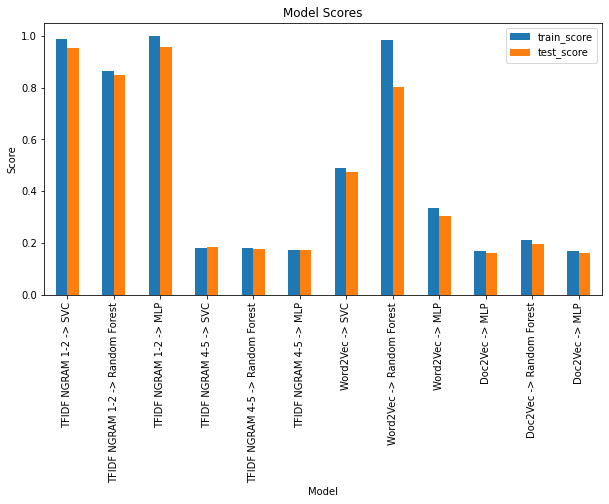

In [98]:
# display the scores table as a bar chart
scores_table.plot.bar(x='model', y=['train_score', 'test_score'], rot=0, figsize=(10, 5))
plt.xticks(rotation=90)
# title and labels
plt.title('Model Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

In [94]:
# display and sort the scores table by test score
scores_table.sort_values(by='test_score', ascending=False)

,model,train_score,test_score
2,TFIDF NGRAM 1-2 -> MLP,0.99900,0.955
0,TFIDF NGRAM 1-2 -> SVC,0.98725,0.952
1,TFIDF NGRAM 1-2 -> Random Forest,0.86300,0.847
7,Word2Vec -> Random Forest,0.98550,0.802
6,Word2Vec -> SVC,0.48900,0.473
8,Word2Vec -> MLP,0.33575,0.306
10,Doc2Vec -> Random Forest,0.21025,0.198
3,TFIDF NGRAM 4-5 -> SVC,0.18175,0.184
4,TFIDF NGRAM 4-5 -> Random Forest,0.18150,0.178
5,TFIDF NGRAM 4-5 -> MLP,0.17325,0.175
